# ML model to predict retweets based on text of document (Doc2Vec)

In [70]:
import pandas as pd
import gensim
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import ast

In [71]:
twts= pd.read_csv('../Data/BrewersAssoc.csv', encoding='latin')
#df2 = pd.read_csv('../Data/craftbeerdotcom.csv', encoding='latin')
#df3 = pd.read_csv('../Data/HomebrewAssoc.csv', encoding='latin')
tags = pd.read_csv('../Data/hashtags.csv', encoding='latin')
#twtids = [df,df2,df3]
#twts = pd.concat(twtids)

In [72]:
list(twts.columns)

['Unnamed: 0',
 'contributors',
 'coordinates',
 'created_at',
 'entities',
 'extended_entities',
 'favorite_count',
 'favorited',
 'geo',
 'id',
 'id_str',
 'in_reply_to_screen_name',
 'in_reply_to_status_id',
 'in_reply_to_status_id_str',
 'in_reply_to_user_id',
 'in_reply_to_user_id_str',
 'is_quote_status',
 'lang',
 'place',
 'possibly_sensitive',
 'quoted_status',
 'quoted_status_id',
 'quoted_status_id_str',
 'retweet_count',
 'retweeted',
 'retweeted_status',
 'source',
 'text',
 'truncated',
 'user']

In [73]:
tags.indices = tags.indices.apply(lambda x: ast.literal_eval(x))
Stst= pd.DataFrame(tags.indices.values.tolist(), index= tags.index,columns=['start','end'])
tags = tags.join(Stst)
minstart = pd.DataFrame(tags.groupby('tweet_id')['start'].min())
tags = tags.merge(minstart, left_on='tweet_id', right_index=True)
print(len(tags))
tags = tags[tags.start_x == tags.start_y]
print(len(tags))
tags.head()


16697
5958


,indices,text,tweet_id,start_x,end,start_y
0,"[64, 72]",brewing,961000377490526209,64,72,64
1,"[51, 57]",beers,960948770618912769,51,57,51
3,"[50, 58]",beerbiz,960897807581196288,50,58,50
5,"[43, 51]",brewery,960872025983275010,43,51,43
6,"[33, 41]",brewery,960591421618126849,33,41,33


In [74]:
twtText = twts[['id','text','truncated','retweet_count']].copy()
print(len(twtText))
twtText = twtText.merge(tags[['tweet_id','text', 'start_y','end']], left_on='id', right_on='tweet_id', how='left')
print(len(twtText))
twtText['text_y'] = twtText['text_y'].str.lower()
twtText.head()

3200
3200


,id,text_x,truncated,retweet_count,tweet_id,text_y,start_y,end
0,961021728427298816,~75% of the barley grown in the US is produced...,True,5,NaN,NaN,NaN,NaN
1,961000377490526209,"""@CrystalLakeBrew represents the very definiti...",True,3,9.610004e+17,brewing,64.0,72.0
2,960948770618912769,"The concept of ""new"". The how and why to add g...",False,0,9.609488e+17,beers,51.0,57.0
3,960897807581196288,An awesome new benefit for all BA voting membe...,False,0,9.608978e+17,beerbiz,50.0,58.0
4,960895367813345280,RT @LottePeplow: @BrewersAssoc will be at @cra...,False,2,NaN,NaN,NaN,NaN


#### These functions remove hashtags/links/usernames/puncuation from a tweet
Thanks https://stackoverflow.com/questions/8376691/how-to-remove-hashtag-user-link-of-a-tweet-using-regular-expression

In [75]:
import re,string

def strip_links(text):
    link_regex    = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)
    links         = re.findall(link_regex, text)
    for link in links:
        text = text.replace(link[0], ', ')    
    return text

def strip_all_entities(text):
    entity_prefixes = ['@','#']
    for separator in  string.punctuation:
        if separator not in entity_prefixes :
            text = text.replace(separator,' ')
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                words.append(word)
    return ' '.join(words)

In [76]:
twtText['parsedText'] = twtText.text_x.apply(lambda x: str.lower(strip_all_entities(strip_links(x))))
print(twtText.text_x[1])
print(twtText.parsedText[1])
twtText.head()

"@CrystalLakeBrew represents the very definition of local craft #brewing." Founded by longtime friends, they strong https://t.co/Xv0zmi7eqj
represents the very definition of local craft founded by longtime friends they strong


,id,text_x,truncated,retweet_count,tweet_id,text_y,start_y,end,parsedText
0,961021728427298816,~75% of the barley grown in the US is produced...,True,5,NaN,NaN,NaN,NaN,75 of the barley grown in the us is produced i...
1,961000377490526209,"""@CrystalLakeBrew represents the very definiti...",True,3,9.610004e+17,brewing,64.0,72.0,represents the very definition of local craft ...
2,960948770618912769,"The concept of ""new"". The how and why to add g...",False,0,9.609488e+17,beers,51.0,57.0,the concept of new the how and why to add gues...
3,960897807581196288,An awesome new benefit for all BA voting membe...,False,0,9.608978e+17,beerbiz,50.0,58.0,an awesome new benefit for all ba voting members
4,960895367813345280,RT @LottePeplow: @BrewersAssoc will be at @cra...,False,2,NaN,NaN,NaN,NaN,rt will be at with a diverse innovative range ...


# FUTURE SPENCER YOU ARE HERE. You are now trying to prescribe an appropreate hashtag based on the content of the message
#### To do this, you still need to strip the text of the current hashtag(s) and then re define the documents similar to bellow
#### after this we should be able to predict best hashtags, hopfully with alright accuracy

In [77]:
def read_corpus(df,col, tokens_only=False):
    for index, row in df.iterrows():
        yield gensim.models.doc2vec.TaggedDocument(row[col], [index])

In [78]:
test = list(read_corpus(df = twtText, col = 'parsedText'))
test[:2]

[TaggedDocument(words='75 of the barley grown in the us is produced in 5 states do you know which ones', tags=[0]),
 TaggedDocument(words='represents the very definition of local craft founded by longtime friends they strong', tags=[1])]

In [79]:
#twtText['tokens'] = twtText['text'].apply(lambda x: gensim.utils.simple_preprocess(x))

In [80]:
twtText.head()

,id,text_x,truncated,retweet_count,tweet_id,text_y,start_y,end,parsedText
0,961021728427298816,~75% of the barley grown in the US is produced...,True,5,NaN,NaN,NaN,NaN,75 of the barley grown in the us is produced i...
1,961000377490526209,"""@CrystalLakeBrew represents the very definiti...",True,3,9.610004e+17,brewing,64.0,72.0,represents the very definition of local craft ...
2,960948770618912769,"The concept of ""new"". The how and why to add g...",False,0,9.609488e+17,beers,51.0,57.0,the concept of new the how and why to add gues...
3,960897807581196288,An awesome new benefit for all BA voting membe...,False,0,9.608978e+17,beerbiz,50.0,58.0,an awesome new benefit for all ba voting members
4,960895367813345280,RT @LottePeplow: @BrewersAssoc will be at @cra...,False,2,NaN,NaN,NaN,NaN,rt will be at with a diverse innovative range ...


In [81]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=100, min_count=2, epochs=500, workers=4)

In [82]:
model.build_vocab(test)

In [83]:
%time model.train(test, total_examples=model.corpus_count, epochs=model.epochs)

Wall time: 1min 27s


## Create DocVectors, will be used as features for ML model

In [84]:
twtText['docVec'] = twtText.parsedText.apply(lambda x : model.infer_vector(x))
twtText.head()

,id,text_x,truncated,retweet_count,tweet_id,text_y,start_y,end,parsedText,docVec
0,961021728427298816,~75% of the barley grown in the US is produced...,True,5,NaN,NaN,NaN,NaN,75 of the barley grown in the us is produced i...,"[0.0835477, -0.0520397, -0.0237852, 0.224665, ..."
1,961000377490526209,"""@CrystalLakeBrew represents the very definiti...",True,3,9.610004e+17,brewing,64.0,72.0,represents the very definition of local craft ...,"[-0.129798, 0.00309063, -0.372665, 0.325803, 0..."
2,960948770618912769,"The concept of ""new"". The how and why to add g...",False,0,9.609488e+17,beers,51.0,57.0,the concept of new the how and why to add gues...,"[0.0583688, -0.268676, 0.0770097, 0.0411815, 0..."
3,960897807581196288,An awesome new benefit for all BA voting membe...,False,0,9.608978e+17,beerbiz,50.0,58.0,an awesome new benefit for all ba voting members,"[-0.0534776, -0.267487, 0.0305778, -0.106771, ..."
4,960895367813345280,RT @LottePeplow: @BrewersAssoc will be at @cra...,False,2,NaN,NaN,NaN,NaN,rt will be at with a diverse innovative range ...,"[-0.200694, 0.328279, -0.155725, 0.00124396, -..."


# Predict best Hashtag 
##### (a good hashtag mean lots of retweets right!?)

In [85]:
X = np.array(twtText.docVec[pd.isna(twtText.text_y) != True].tolist())
y = twtText.text_y.values[pd.isna(twtText.text_y) != True]
len(pd.unique(twtText['text_y']))

165

In [86]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X,y)
print(clf.score(X,y))
#print(clf.classes_)
for x in [0,1,2,3,4,5,6,7]:
    print(clf.predict([twtText.docVec[x]]))
    print([clf.predict_proba([twtText.docVec[x]])[0][i] for i in np.argsort(clf.predict_proba([twtText.docVec[x]]))[0][-5:]])
    print([clf.classes_[i] for i in np.argsort(clf.predict_proba([twtText.docVec[x]]))[0][-5:]])
    #print(clf.predict_proba([twtText.docVec[x]]),twtText.text_y[x])
    print(twtText.text_x[x])

0.283171521036
['beer']
[0.055079133349073994, 0.059537145116004733, 0.069909612683287312, 0.15170099968246398, 0.15542974580156446]
['savor', 'cbc16', 'cbc17', 'beer', 'beerbiz']
~75% of the barley grown in the US is produced in 5 states, do you know which ones? https://t.co/fmISNP4twQ https://t.co/GFEvcO5Ayh
['beer']
[0.053623413902221514, 0.066439877818418855, 0.093450353612366963, 0.15162407782375992, 0.15885491914876224]
['cbc16', 'craftbeer', 'brewery', 'beer', 'beerbiz']
"@CrystalLakeBrew represents the very definition of local craft #brewing." Founded by longtime friends, they strong https://t.co/Xv0zmi7eqj
['beer']
[0.052357063077795085, 0.082734865833696769, 0.084236327516989187, 0.10710789168418258, 0.36151292156948872]
['independentbeer', 'beerbiz', 'brewery', 'craftbeer', 'beer']
The concept of "new". The how and why to add guest #beers in your taproom. https://t.co/C3V5Jq8RWu #beerbiz https://t.co/UyBpZJHAQm
['beer']
[0.040638799877630909, 0.07198562410591057, 0.0886205

In [87]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(max_depth=10,n_estimators=100,random_state=0, n_jobs=-1)
clf2.fit(X,y)
print(clf2.score(X,y))
#print(clf2.feature_importances_)
#print(clf.classes_)
for x in [0,1,2,3,4,5,6,7]:
    print(clf2.predict([twtText.docVec[x]]))
    print(twtText.text_y[x])
    print([clf2.predict_proba([twtText.docVec[x]])[0][i] for i in np.argsort(clf2.predict_proba([twtText.docVec[x]]))[0][-5:]])
    print([clf2.classes_[i] for i in np.argsort(clf2.predict_proba([twtText.docVec[x]]))[0][-5:]])
    #print(clf.predict_proba([twtText.docVec[x]]),twtText.text_y[x])
    print(twtText.text_x[x])

0.850053937433
['beerbiz']
nan
[0.06542820589448517, 0.07616197935637524, 0.082540453842614825, 0.16360615263669051, 0.25913916159407513]
['cbc17', 'craftbeer', 'brewery', 'beer', 'beerbiz']
~75% of the barley grown in the US is produced in 5 states, do you know which ones? https://t.co/fmISNP4twQ https://t.co/GFEvcO5Ayh
['brewing']
brewing
[0.058806011219987304, 0.064795508527379683, 0.085187034185179561, 0.1097088115825496, 0.33269307109652124]
['cbc16', 'craftbeer', 'beer', 'beerbiz', 'brewing']
"@CrystalLakeBrew represents the very definition of local craft #brewing." Founded by longtime friends, they strong https://t.co/Xv0zmi7eqj
['beer']
beers
[0.087812864678528571, 0.092908446997775174, 0.096071778586327039, 0.20158357091974452, 0.28132387912124512]
['craftbeer', 'brewery', 'beerbiz', 'beers', 'beer']
The concept of "new". The how and why to add guest #beers in your taproom. https://t.co/C3V5Jq8RWu #beerbiz https://t.co/UyBpZJHAQm
['beerbiz']
beerbiz
[0.033366418013624652, 0.

# Attempt at regression, there is low predictablity

In [33]:
X = np.array(twtText['docVec'].tolist())


#### Ridge Regression ($R^2$=3.2%)

In [34]:
from sklearn import linear_model
n_alphas = 500
alph = np.logspace(.01, 100, n_alphas)
#print(alph)
reg = linear_model.RidgeCV(alphas=alph, store_cv_values=True)
reg.fit(X, y)
print(reg.alpha_)
#print(reg.get_params())
#print(reg.coef_)
#print(reg.cv_values_)
print(reg.score(X=np.array(twtText['docVec'].tolist()), y=twtText['retweet_count'].values))


#coefs = []
#for a in alph:
#    ridge = linear_model.Ridge(alpha=a, fit_intercept=False)
#    ridge.fit(X = np.array(twtText['docVec'].tolist()), y=twtText['retweet_count'].values)
#    coefs.append(ridge.coef_)
    
# #############################################################################
# Display results

#ax = plt.gca()

#ax.plot(alph, coefs)
#ax.set_xscale('log')
#ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
#plt.xlabel('alpha', color='yellow')
#plt.ylabel('weights', color='yellow')
#plt.title('Ridge coefficients as a function of the regularization', color='yellow')
#plt.axis('tight', color='yellow')
#plt.tick_params(colors='yellow')
#plt.show()

163.752665033
0.0318297309007


In [35]:
print(reg.predict([twtText.docVec[0]]),twtText.retweet_count[0])
print(reg.predict([twtText.docVec[1]]),twtText.retweet_count[1])
print(reg.predict([twtText.docVec[2]]),twtText.retweet_count[2])

[ 9.42641859] 5
[ 7.03437221] 3
[ 5.7813788] 0


#### Lasso Regression ($R^2$=2.2%)

Computing regularization path using the coordinate descent lasso...


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.0223040412678


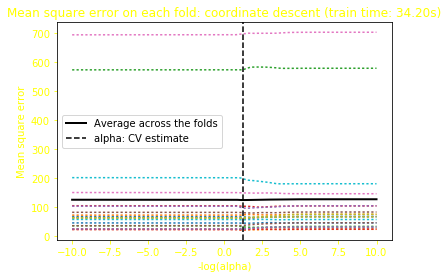

In [36]:
# #############################################################################
# LassoCV: coordinate descent
import time
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC

alph = np.logspace(-10, 10, n_alphas)
#print(alph)
# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20,alphas = alph).fit(X, y)
t_lasso_cv = time.time() - t1
print(model.score(X,y))

# Display results
m_log_alphas = -np.log10(model.alphas_)
#print(m_log_alphas)

plt.figure()
#ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',
         label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',
            label='alpha: CV estimate')

plt.legend()

plt.xlabel('-log(alpha)', color = 'yellow')
plt.ylabel('Mean square error', color = 'yellow')
plt.title('Mean square error on each fold: coordinate descent '
          '(train time: %.2fs)' % t_lasso_cv, color = 'yellow')
plt.axis('tight')
#plt.ylim(ymin, ymax)
plt.tick_params(colors='yellow')
plt.show()

# Looks like we are not getting much for predictablilty, lets classify low(<3) medium(<=5) high(>5)

In [37]:
twtText['retweet_class'] = twtText.retweet_count.apply(lambda x: 'low(<3)' if x<3 else 'medium(>=3,<=5)' if x<=5 else 'high(>5)' )
twtText.head()

,id,text_x,truncated,retweet_count,tweet_id,text_y,start_y,end,parsedText,docVec,retweet_class
0,961021728427298816,~75% of the barley grown in the US is produced...,True,5,NaN,NaN,NaN,NaN,75 of the barley grown in the US is produced i...,"[0.396371, 0.38316, -0.72992, -0.243998, -0.24...","medium(>=3,<=5)"
1,961000377490526209,"""@CrystalLakeBrew represents the very definiti...",True,3,9.610004e+17,brewing,64.0,72.0,represents the very definition of local craft ...,"[0.148189, 0.259472, 0.139787, -0.00163876, -0...","medium(>=3,<=5)"
2,960948770618912769,"The concept of ""new"". The how and why to add g...",False,0,9.609488e+17,beers,51.0,57.0,The concept of new The how and why to add gues...,"[0.226059, -0.0300769, 0.229013, -0.133485, 0....",low(<3)
3,960897807581196288,An awesome new benefit for all BA voting membe...,False,0,9.608978e+17,beerbiz,50.0,58.0,An awesome new benefit for all BA voting members,"[0.167138, -0.0332243, 0.0234007, -0.14369, 0....",low(<3)
4,960895367813345280,RT @LottePeplow: @BrewersAssoc will be at @cra...,False,2,NaN,NaN,NaN,NaN,RT will be at with a diverse innovative range ...,"[0.332563, 0.227647, -0.487932, 0.167555, 0.18...",low(<3)


In [38]:
y = twtText['retweet_class'].values

In [39]:
from sklearn.svm import SVC
clf = SVC(probability=True)
clf.fit(X,y)
clf.score(X,y)
print(clf.classes_)
for x in [0,1,2,3,4,5,6,7]:
    print(clf.predict([twtText.docVec[x]]),clf.predict_proba([twtText.docVec[x]]),twtText.retweet_class[x])


['high(>5)' 'low(<3)' 'medium(>=3,<=5)']
['high(>5)'] [[ 0.45116468  0.22350865  0.32532667]] medium(>=3,<=5)
['high(>5)'] [[ 0.39826551  0.31521527  0.28651922]] medium(>=3,<=5)
['medium(>=3,<=5)'] [[ 0.28973155  0.33494245  0.375326  ]] low(<3)
['high(>5)'] [[ 0.30899809  0.3691094   0.32189251]] low(<3)
['high(>5)'] [[ 0.37623731  0.28558119  0.3381815 ]] low(<3)
['high(>5)'] [[ 0.38933068  0.33982553  0.27084379]] medium(>=3,<=5)
['high(>5)'] [[ 0.37631359  0.29787171  0.32581469]] medium(>=3,<=5)
['high(>5)'] [[ 0.38275924  0.36287998  0.25436078]] medium(>=3,<=5)


# Run Similarities

In [13]:
ranks = []
second_ranks = []
for doc_id in range(len(test)):
    inferred_vector = model.infer_vector(test[doc_id].words)
    sims = model.docvecs.most_similar([inferred_vector], topn=len(model.docvecs))
    rank = [docid for docid, sim in sims]
    ranks.append(rank)
    
    second_ranks.append(sims[1])

In [14]:
ranks[0][0:10]

[456, 354, 628, 1472, 152, 1293, 133, 0, 911, 573]

In [15]:
ids = [0, 152, 269, 15, 1905, 2200, 2072, 2288, 140, 2006]
for doc_id in ids:
    print('Train Document ({}): «{}»\n'.format(doc_id, ''.join(test[doc_id].words)))
    sim_id = second_ranks[doc_id]
    print('Similar Document {}: «{}»\n'.format(sim_id, ''.join(test[sim_id[0]].words)))

Train Document (0): «~75% of the barley grown in the US is produced in 5 states, do you know which ones? »

Similar Document (354, 0.7506328225135803): «Which 5 states produce ~75% of the barley grown in the US?  #beerbiz »

Train Document (152): «5 states produce ~75% of the barley grown in the US, do you know which ones? »

Similar Document (1472, 0.7079355716705322): «How many of the Top 50 breweries have you visited? - »

Train Document (269): «5 states produce ~75% of the barley grown in the US, do you know which ones? #beerbiz #craftbeer »

Similar Document (152, 0.6305805444717407): «5 states produce ~75% of the barley grown in the US, do you know which ones? »

Train Document (15): «Cans and bottles, craft #brewery packaging trends in 2017. »

Similar Document (2619, 0.47364863753318787): «#SAVOR Week Events kick off today! Check out the tap room takeovers, happy hours, parties and delicious #craftbeer! »

Train Document (1905): «Looking to start a career in the brewing indust